In [ ]:
!kaggle datasets download -d nelgiriyewithana/emotions

Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/emotions
License(s): other
 83% 13.0M/15.7M [00:01<00:00, 14.5MB/s]
100% 15.7M/15.7M [00:01<00:00, 10.7MB/s]


In [ ]:
!unzip emotions.zip -d /content/emotions

Archive:  emotions.zip
  inflating: /content/emotions/text.csv  


# Importing

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/emotions/text.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
df.drop(columns="Unnamed: 0", inplace=True)
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
emotion_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}
df["label"] = df["label"].map(emotion_map)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


# Pre Processing

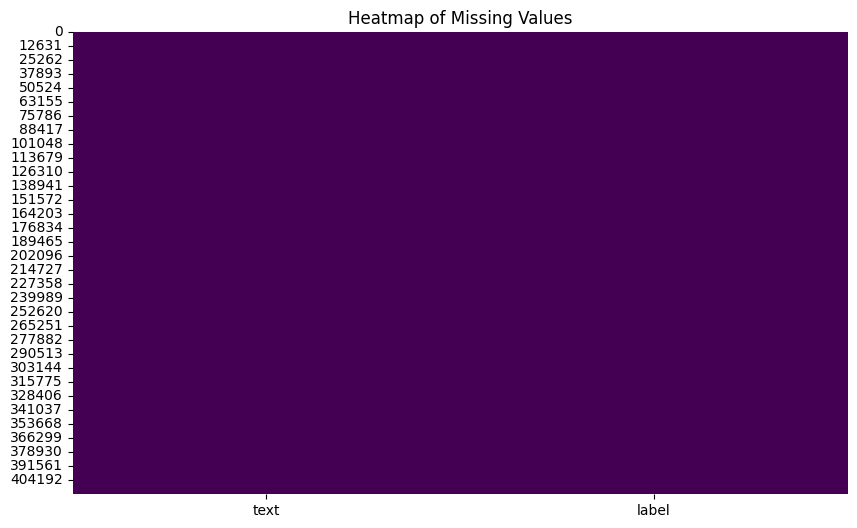

In [ ]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a heatmap to visualize missing values
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

# Display the plot
plt.title('Heatmap of Missing Values')
plt.show()

In [ ]:
# Identify duplicate rows
duplicate_rows = df.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicate_rows.sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 686


In [ ]:
# Remove exact duplicates, keeping the first occurrence
df = df.drop_duplicates()
print(f"DataFrame shape after removing exact duplicates: {df.shape}")

DataFrame shape after removing exact duplicates: (416123, 2)


In [ ]:
# Calculate the length of each text entry
df['text_length'] = df['text'].apply(len)

# Display basic statistics
print(df['text_length'].describe())

count    416123.000000
mean         97.102662
std          56.176302
min           2.000000
25%          54.000000
50%          86.000000
75%         128.000000
max         830.000000
Name: text_length, dtype: float64


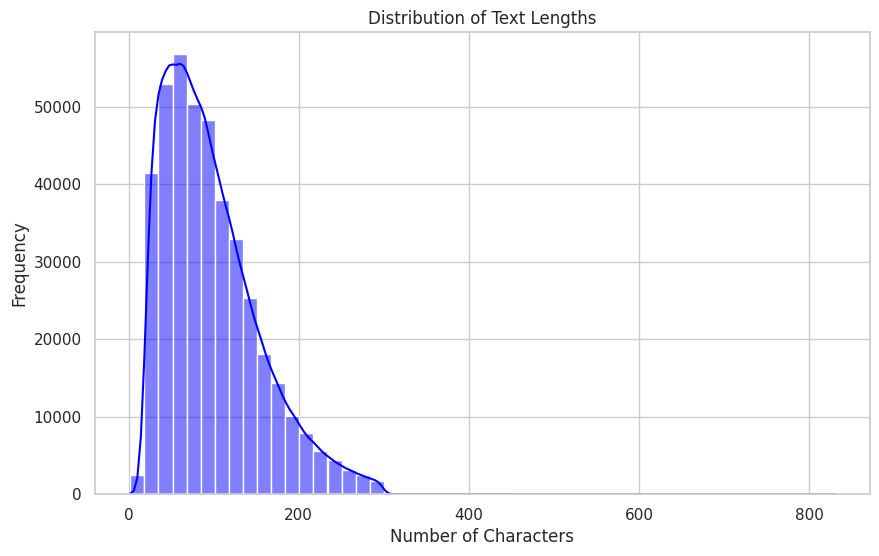

In [ ]:
# Set plot style
sns.set(style="whitegrid")

# Plot distribution of text lengths
plt.figure(figsize=(10,6))
sns.histplot(df['text_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

Number of text length outliers: 9952


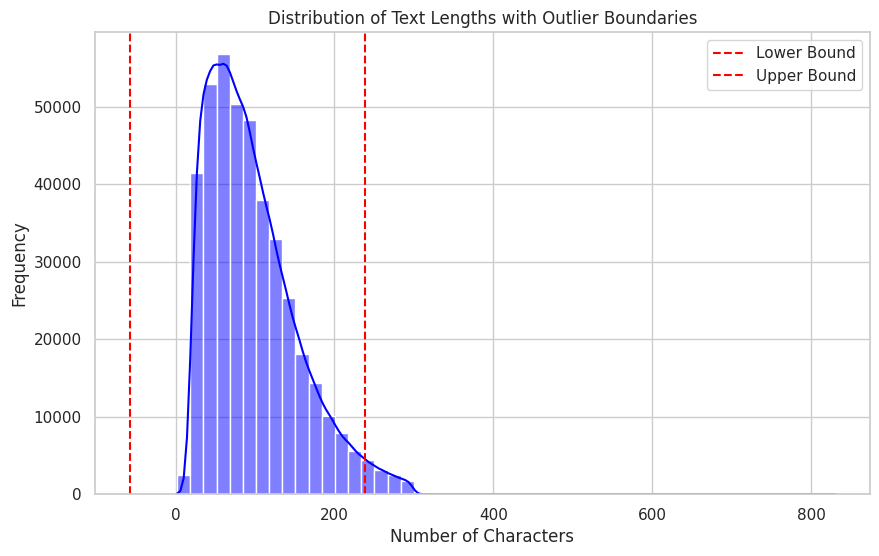

In [ ]:
# Calculate Q1 and Q3
Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_length = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]
print(f"Number of text length outliers: {outliers_length.shape[0]}")

plt.figure(figsize=(10,6))
sns.histplot(df['text_length'], bins=50, kde=True, color='blue')
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='red', linestyle='--', label='Upper Bound')
plt.title('Distribution of Text Lengths with Outlier Boundaries')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
def feature_outlier_analysis(df, feature, start=None, end=None, mode=0, save_filename=None):
    """
    Analyze and identify outliers based on a numerical feature.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - feature (str): The numerical feature to analyze.
    - start (int, optional): The starting value of the feature to consider. Defaults to the minimum value.
    - end (int, optional): The ending value of the feature to consider. Defaults to the maximum value.
    - mode (int, optional): If not zero, saves the subset to CSV. Defaults to 0.
    - save_filename (str, optional): The filename to save the subset if mode != 0.

    Returns:
    - None
    """
    # Ensure the feature exists in the DataFrame
    if feature not in df.columns:
        print(f"Feature '{feature}' not found in the DataFrame.")
        return

    # Set default start and end if not provided
    if start is None:
        start = int(df[feature].min())
    if end is None:
        end = int(df[feature].max())

    print(f"Analyzing feature '{feature}' from {start} to {end}.")

    # Iterate over the specified range
    for i in range(start, end + 1):
        subset = df[df[feature] == i]
        count = len(subset)
        print(f"Feature '{feature}' = {i}: {count} entries.")

        # Save to CSV if mode is not zero
        if mode != 0 and save_filename:
            subset.to_csv(save_filename, mode='a', index=False)  # Append to the file

    print("Feature outlier analysis completed.")

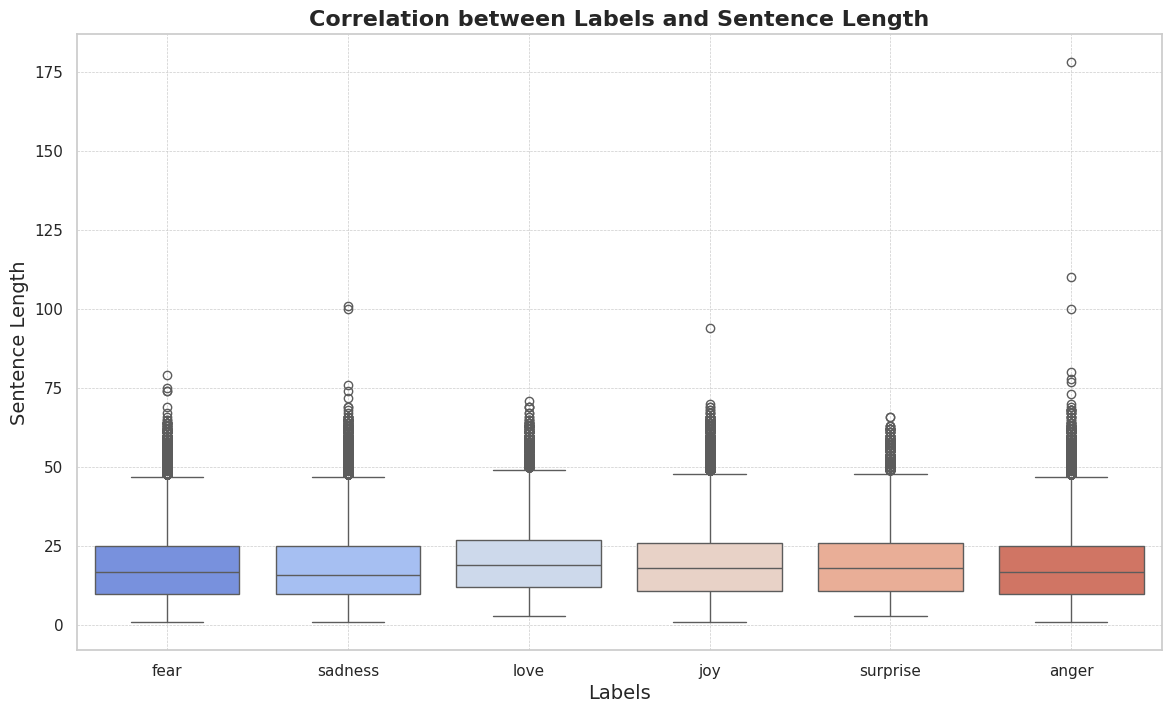

In [ ]:
# Calculate sentence length using vectorized string operations
df['sentence_length'] = df['text'].str.split().str.len()

plt.figure(figsize=(14, 8))
sns.boxplot(x='label', y='sentence_length', data=df, palette="coolwarm")
plt.title('Correlation between Labels and Sentence Length', fontsize=16, fontweight='bold')
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Sentence Length", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
def sentence_length_outlier(start=1, end=2, save_csv=False):
    """
    Identifies and optionally saves DataFrame rows with sentence lengths within a specified range.

    Parameters:
    - start (int): Starting sentence length (inclusive).
    - end (int): Ending sentence length (exclusive).
    - save_csv (bool): If True, saves each group to a separate CSV file.

    Returns:
    - outliers (dict): A dictionary with sentence lengths as keys and corresponding DataFrames as values.
    """
    outliers = {}
    for length in range(start, end):
        filtered_df = df[df['sentence_length'] == length]
        count = len(filtered_df)

        print(f"Sentence length {length} has {count} occurrences.")

        if count > 0:
            outliers[length] = filtered_df
            if save_csv:
                filename = f"df_sentence_length_{length}.csv"
                filtered_df.to_csv(filename, index=False)
                print(f"Saved {count} records to {filename}")

    return outliers

# Example usage:
outlier_data = sentence_length_outlier(start=1, end=5, save_csv=True)

Sentence length 1 has 25 occurrences.
Saved 25 records to df_sentence_length_1.csv
Sentence length 2 has 76 occurrences.
Saved 76 records to df_sentence_length_2.csv
Sentence length 3 has 957 occurrences.
Saved 957 records to df_sentence_length_3.csv
Sentence length 4 has 7539 occurrences.
Saved 7539 records to df_sentence_length_4.csv


In [ ]:
# Define the sentence lengths to remove
lengths_to_remove = [1, 2, 3]

# Filter the DataFrame to exclude these lengths
df= df[~df['sentence_length'].isin(lengths_to_remove)].copy()

# Optionally, reset the index for cleanliness
df.reset_index(drop=True, inplace=True)

# Optional: Save the filtered DataFrame for future use
df.to_csv("df_filtered_sentence_length.csv", index=False)
print(f"Filtered DataFrame saved with {len(df)} records.")

Filtered DataFrame saved with 415065 records.


In [ ]:
df.shape

(415065, 4)

In [ ]:
# Get the 10 longest sentences and their indices
top_sentences = df.sort_values(by='sentence_length', ascending=False).head(20)
top_indices = top_sentences.index

# Display the top sentences
print("Top 20 Longest Sentences:")
print(top_sentences[['text', 'sentence_length']])

Top 20 Longest Sentences:
                                                     text  sentence_length
347001  a few days back i was waiting for the bus at t...              178
290349  two years back someone invited me to be the tu...              110
97687   i have been thinking of changing my major for ...              101
38584   when i got into a bus i found that my wallet h...              100
22750   my living and working conditions at home were ...              100
332276  i had a dream i had a very close friend who ha...               94
249491  i worked with several classmates on a project ...               80
158527  i was camping in an old broken hut which had n...               79
56688   last semester when i dated a girl whom ive kno...               78
162121  i was a prefect at secondary school on the spo...               77
174240  when i was in lower six class during the summe...               76
387931  a boy phoned me at night and wanted to talk to...               75

In [ ]:
df = df.drop(index=[348392, 291479, 97990, 38708, 22827, 333596])

In [ ]:
df.shape

(415059, 4)

## Data Cleaning

In [ ]:
import re
import string
import unicodedata

# Pre-compile regex patterns for efficiency
HTML_TAG_RE = re.compile(r'<.*?>', re.DOTALL)
URL_RE = re.compile(r'https?://\S+|www\.\S+')
NUMERIC_RE = re.compile(r'\d+')
NON_ALPHANUMERIC_RE = re.compile(r'[^a-zA-Z\s]')
EXTRA_WHITESPACE_RE = re.compile(r'\s+')
EMOJI_RE = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
    "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
    "\U0001F1E0-\U0001F1FF"  # Flags
    "]+",
    flags=re.UNICODE
)

def processing_data(text):
    """
    Preprocesses the input text by performing the following operations:
    1. Removes HTML tags.
    2. Removes URLs.
    3. Removes emojis and non-standard Unicode characters.
    4. Removes numeric values.
    5. Removes non-alphanumeric characters (excluding spaces).
    6. Converts text to lowercase.
    7. Removes extra whitespaces.
    8. Strips leading and trailing whitespaces.

    Parameters:
    - text (str): The input text to preprocess.

    Returns:
    - str: The cleaned and preprocessed text.
    """
    if pd.isnull(text) or not isinstance(text, str):
        return ""

    # Normalize unicode characters
    text = unicodedata.normalize('NFKD', text)

    # Remove HTML tags
    text = HTML_TAG_RE.sub('', text)

    # Remove URLs
    text = URL_RE.sub('', text)

    # Remove emojis
    text = EMOJI_RE.sub('', text)

    # Remove numeric values
    text = NUMERIC_RE.sub('', text)

    # Remove non-alphanumeric characters (excluding spaces)
    text = NON_ALPHANUMERIC_RE.sub('', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespaces
    text = EXTRA_WHITESPACE_RE.sub(' ', text)

    # Strip leading and trailing whitespaces
    text = text.strip()

    return text

In [ ]:
df['text'] = df['text'].apply(processing_data)

In [ ]:
df.head(20)

,text,label,text_length,sentence_length
0,i just feel really helpless and heavy hearted,fear,45,8
1,ive enjoyed being able to slouch about relax a...,sadness,234,45
2,i gave up my internship with the dmrg and am f...,fear,63,12
3,i dont know i feel so lost,sadness,26,7
4,i am a kindergarten teacher and i am thoroughl...,fear,222,42
5,i was beginning to feel quite disheartened,sadness,42,7
6,i would think that whomever would be lucky eno...,love,125,25
7,i fear that they won t ever feel that deliciou...,joy,124,25
8,im forever taking some time out to have a lie ...,surprise,71,15
9,i can still lose the weight without feeling de...,sadness,52,9


In [ ]:
# Calculate the counts of each emotion
label_counts = df['label'].value_counts()
label_percentages = df['label'].value_counts(normalize=True) * 100

# Create a DataFrame for better readability
label_distribution = pd.DataFrame({
    'Count': label_counts,
    'Percentage': label_percentages.round(2)
})

print(label_distribution)

           Count  Percentage
label                       
joy       140474       33.84
sadness   120692       29.08
anger      57008       13.73
fear       47510       11.45
love       34441        8.30
surprise   14934        3.60


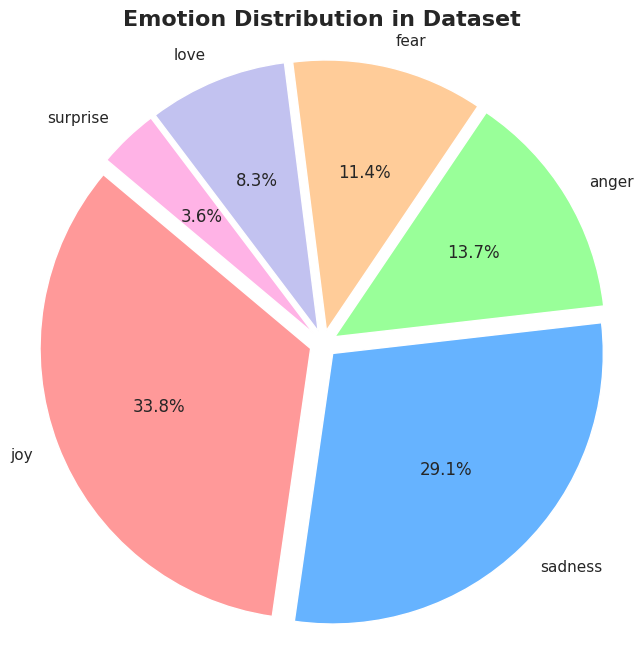

In [ ]:
# Define colors for each emotion
colors = ['#FF9999','#66B3FF','#99FF99','#FFCC99','#C2C2F0','#FFB3E6']

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=(0.05, 0.05, 0.05, 0.05, 0.05, 0.05))
plt.title('Emotion Distribution in Dataset', fontsize=16, fontweight='bold')
plt.axis('equal')  # Ensures that pie is drawn as a circle.
plt.show()

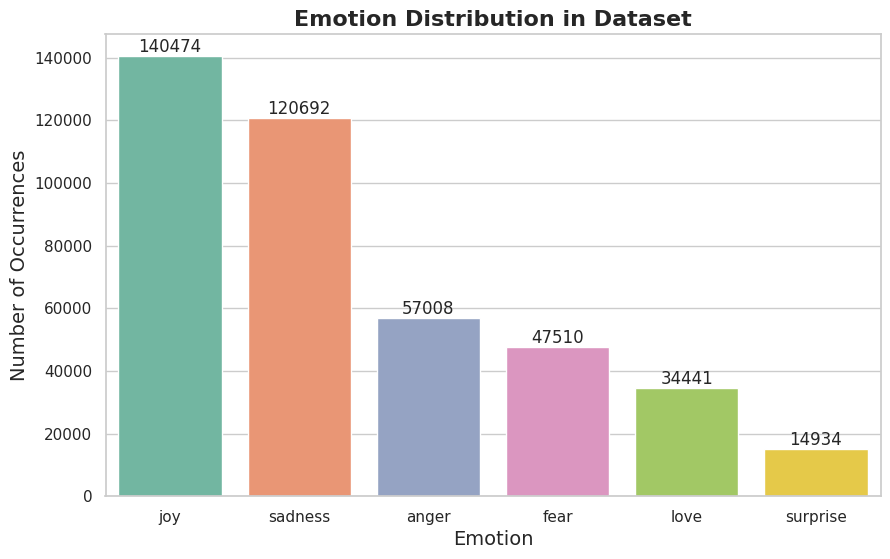

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df, palette="Set2", order=label_counts.index)
plt.title('Emotion Distribution in Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)

# Adding the count labels on top of each bar
for index, value in enumerate(label_counts):
    plt.text(index, value + 50, str(value), ha='center', va='bottom', fontsize=12)

plt.show()

## Preprocessing Lemmatization and Filtering StopWords

In [ ]:
!pip install tqdm

In [ ]:
import time
import re
import spacy
from tqdm import tqdm
import pandas as pd

# Load SpaCy model with parser and NER disabled for efficiency
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Set maximum text length if needed (adjust as per your dataset)
nlp.max_length = 1_500_000

def process_text(doc):
    """
    Processes a SpaCy Doc object by lemmatizing tokens, removing stopwords, and filtering non-alphabetic tokens.

    Parameters:
    - doc (spacy.tokens.Doc): The SpaCy Doc object to process.

    Returns:
    - str: The processed text.
    """
    return ' '.join(
        token.lemma_ for token in doc
        if not token.is_stop and token.is_alpha
    )

def process_texts_sequentially(texts, batch_size=500):
    """
    Processes a list of texts sequentially using SpaCy's nlp.pipe with a progress bar.

    Parameters:
    - texts (list of str): The list of text strings to process.
    - batch_size (int): The number of texts to process in each batch.

    Returns:
    - list of str: The list of processed text strings.
    """
    processed_texts = []

    # Initialize tqdm progress bar
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, disable=["parser", "ner"]), total=len(texts), desc="Processing Texts"):
        processed_text = process_text(doc)
        processed_texts.append(processed_text)

    return processed_texts

if __name__ == "__main__":
    # Load your dataset here
    # Example:
    # df = pd.read_csv("your_data.csv")

    # Ensure that the DataFrame 'df' exists and has a 'text' column
    try:
        df
    except NameError:
        print("Error: DataFrame 'df' is not defined. Please load your data before processing.")
        exit()

    if 'text' not in df.columns:
        print("Error: The DataFrame does not contain a 'text' column.")
        exit()

    # Handle missing texts
    missing_texts = df['text'].isnull().sum()
    if missing_texts > 0:
        print(f"Warning: Found {missing_texts} missing texts. Filling them with empty strings.")
        df['text'] = df['text'].fillna("")

    # Convert the 'text' column to a list
    texts = df['text'].tolist()

    # Start the processing timer
    start_time = time.time()
    print("⏳ Starting text processing...")

    # Process the texts sequentially with a progress bar
    df['processed_text'] = process_texts_sequentially(texts, batch_size=500)

    # End the processing timer
    end_time = time.time()
    processing_time = end_time - start_time
    print(f"✅ Processing completed in {processing_time:.2f} seconds")

⏳ Starting text processing...


Processing Texts: 100%|██████████| 415059/415059 [11:35<00:00, 596.56it/s]

✅ Processing completed in 695.82 seconds


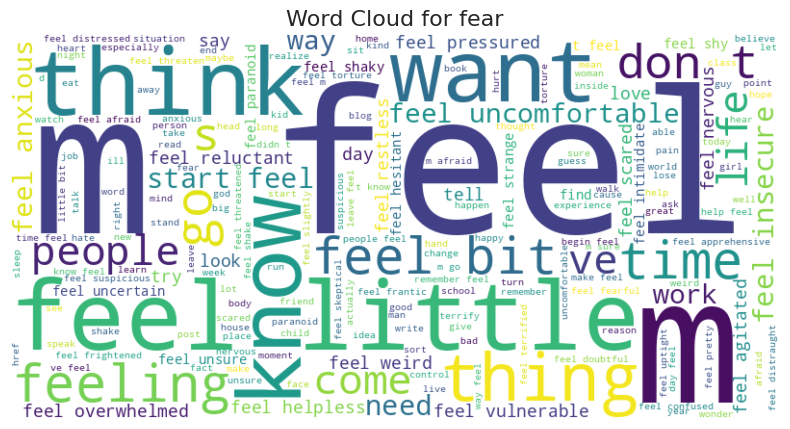

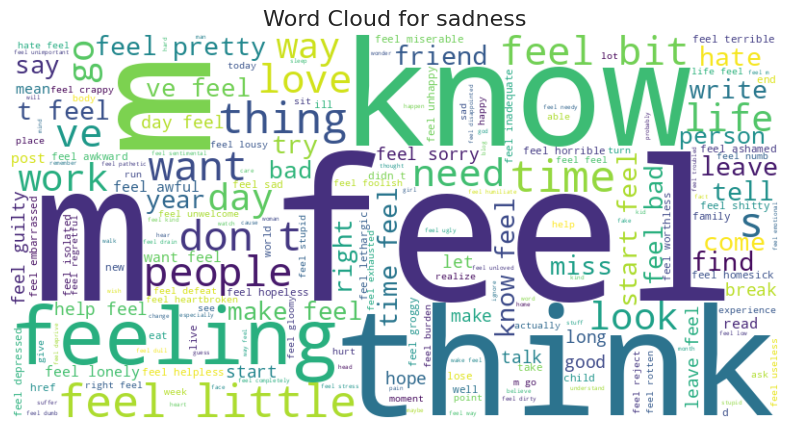

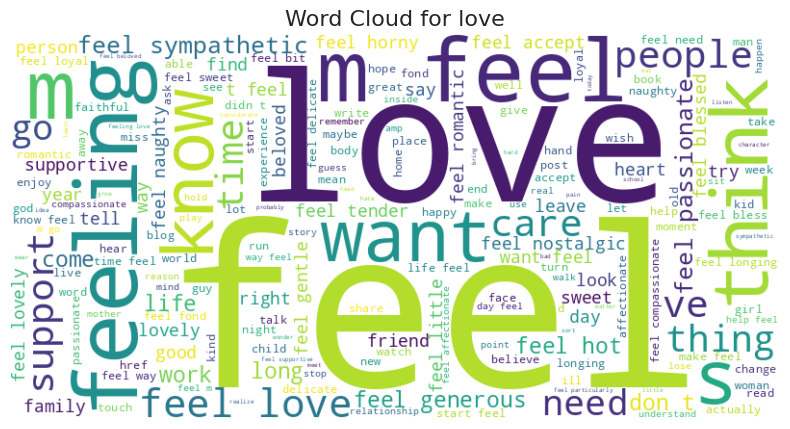

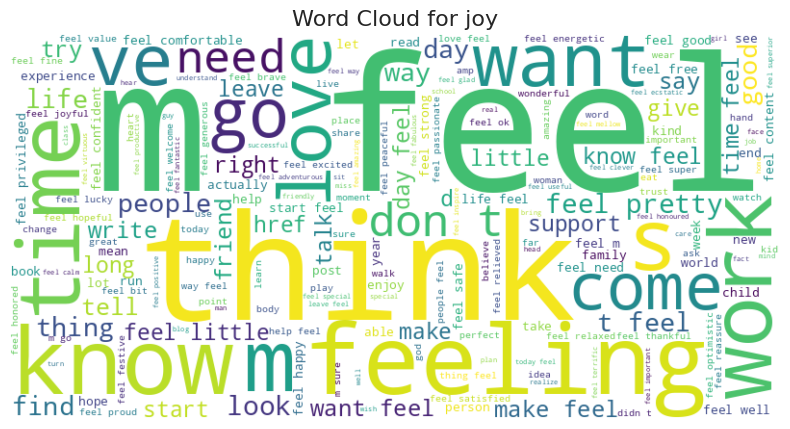

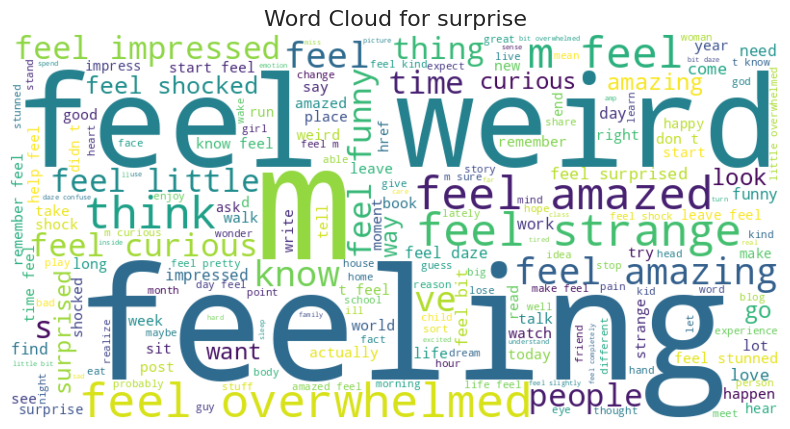

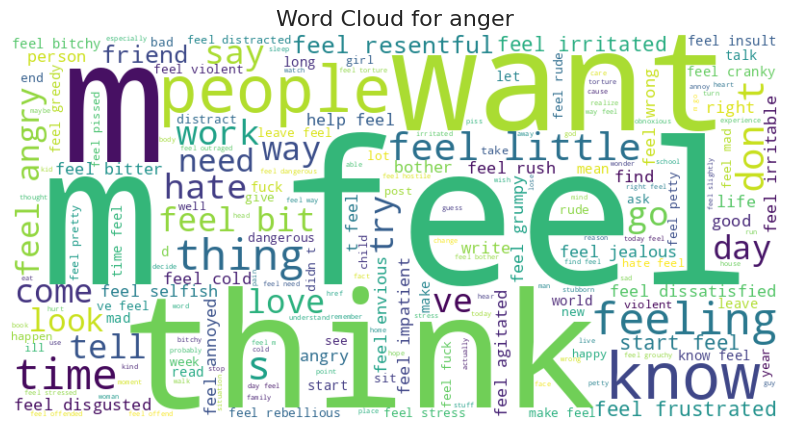

In [ ]:
from wordcloud import WordCloud

for emotion in df['label'].unique():
    subset = df[df['label'] == emotion]
    text = ' '.join(subset['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {emotion}', fontsize=16)
    plt.axis('off')
    plt.show()

## Bag of Words (BoW)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the processed_text
X_bow = vectorizer.fit_transform(df['processed_text'])

print(f"BoW feature matrix shape: {X_bow.shape}")

BoW feature matrix shape: (415059, 62325)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the processed_text
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

print(f"TF-IDF feature matrix shape: {X_tfidf.shape}")

TF-IDF feature matrix shape: (415059, 62325)


## Machine Learning Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# Encode the categorical labels to integers
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])  # Assuming 'label' contains the target classes

# Use the precomputed TF-IDF feature matrix
X = X_tfidf  # Assuming X_tfidf is already created and available
y = df['label_encoded']  # Encoded labels

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split using the resampled data
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Print results
print(f"Training set size (resampled): {X_train_resampled.shape}")
print(f"Testing set size (resampled): {X_test_resampled.shape}")

Training set size (resampled): (674275, 62325)
Testing set size (resampled): (168569, 62325)


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import logging

# Initialize Logistic Regression with desired parameters
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the Logistic Regression model
logging.info("Training Logistic Regression...")
log_reg.fit(X_train_resampled, y_train_resampled)
logging.info("Logistic Regression training completed.")

In [ ]:
# Predict on the test set
y_pred_log_reg = log_reg.predict(X_test_resampled)

# Generate and print the classification report
print("=== Logistic Regression Classification Report ===\n")
print(classification_report(y_test_resampled, y_pred_log_reg))

=== Logistic Regression Classification Report ===

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     28094
           1       0.93      0.88      0.90     28095
           2       0.93      0.88      0.90     28095
           3       0.92      0.95      0.93     28095
           4       0.94      0.91      0.93     28095
           5       0.91      0.98      0.95     28095

    accuracy                           0.93    168569
   macro avg       0.93      0.93      0.93    168569
weighted avg       0.93      0.93      0.93    168569



## Naive Bayes Implementation

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Initialize Multinomial Naive Bayes
naive_bayes_model = MultinomialNB()

# Train the model
naive_bayes_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_nb = naive_bayes_model.predict(X_test_resampled)

# Evaluate the model
print("=== Naive Bayes Classification Report ===\n")
print(classification_report(y_test_resampled, y_pred_nb))

=== Naive Bayes Classification Report ===

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     28094
           1       0.91      0.87      0.89     28095
           2       0.88      0.86      0.87     28095
           3       0.90      0.93      0.91     28095
           4       0.92      0.89      0.90     28095
           5       0.90      0.97      0.93     28095

    accuracy                           0.90    168569
   macro avg       0.90      0.90      0.90    168569
weighted avg       0.90      0.90      0.90    168569



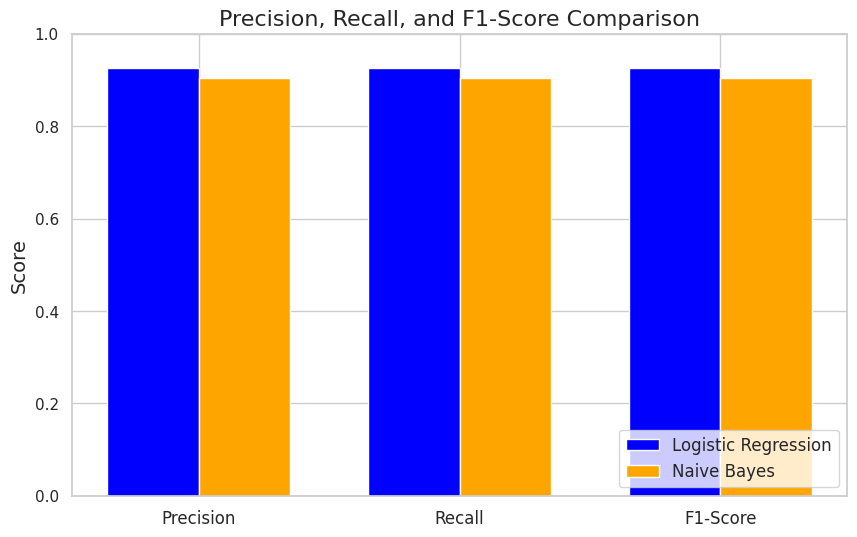

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Get precision, recall, and F1-score for both models
log_reg_metrics = precision_recall_fscore_support(y_test_resampled, y_pred_log_reg, average='weighted')[:3]
naive_bayes_metrics = precision_recall_fscore_support(y_test_resampled, y_pred_nb, average='weighted')[:3]

# Combine the metrics
metrics = np.array([log_reg_metrics, naive_bayes_metrics])
metric_names = ["Precision", "Recall", "F1-Score"]

# Plot the metrics
x = np.arange(len(metric_names))  # Metric categories
width = 0.35  # Width of bars

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, metrics[0], width, label="Logistic Regression", color='blue')
plt.bar(x + width/2, metrics[1], width, label="Naive Bayes", color='orange')

plt.title("Precision, Recall, and F1-Score Comparison", fontsize=16)
plt.xticks(x, metric_names, fontsize=12)
plt.ylabel("Score", fontsize=14)
plt.ylim(0, 1)
plt.legend(loc="lower right", fontsize=12)
plt.show()

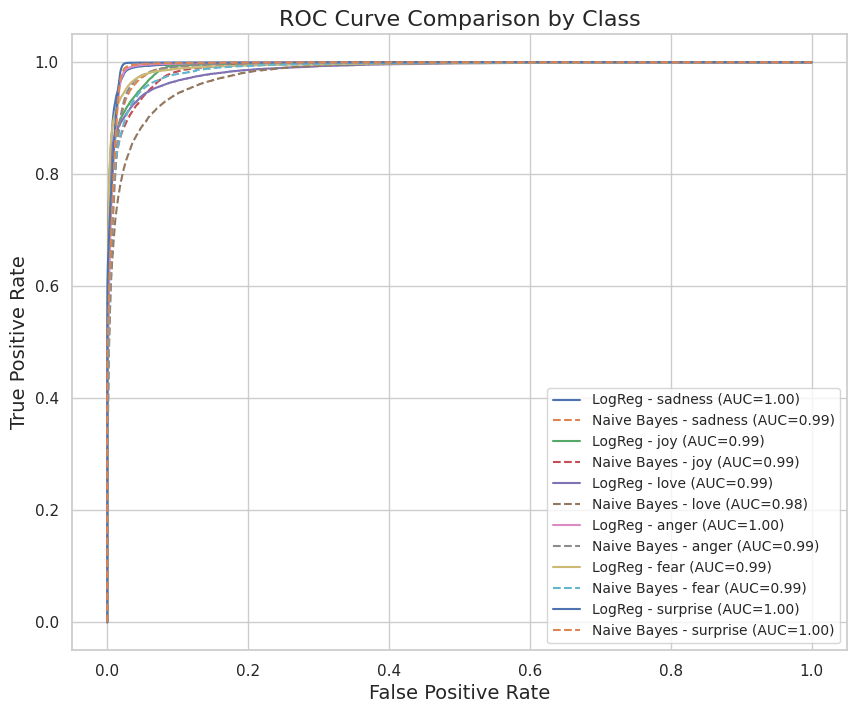

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Class names
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Binarize the labels for multi-class ROC
y_test_binarized = label_binarize(y_test_resampled, classes=np.unique(y_test_resampled))
n_classes = y_test_binarized.shape[1]

# Logistic Regression Probabilities
y_score_log_reg = log_reg.predict_proba(X_test_resampled)

# Naive Bayes Probabilities
y_score_nb = naive_bayes_model.predict_proba(X_test_resampled)

# Plot ROC Curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test_binarized[:, i], y_score_log_reg[:, i])
    fpr_nb, tpr_nb, _ = roc_curve(y_test_binarized[:, i], y_score_nb[:, i])

    plt.plot(fpr_log_reg, tpr_log_reg, label=f"LogReg - {class_names[i]} (AUC={roc_auc_score(y_test_binarized[:, i], y_score_log_reg[:, i]):.2f})")
    plt.plot(fpr_nb, tpr_nb, linestyle='--', label=f"Naive Bayes - {class_names[i]} (AUC={roc_auc_score(y_test_binarized[:, i], y_score_nb[:, i]):.2f})")

plt.title("ROC Curve Comparison by Class", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="best", fontsize=10)
plt.show()

## Confusion Matrix

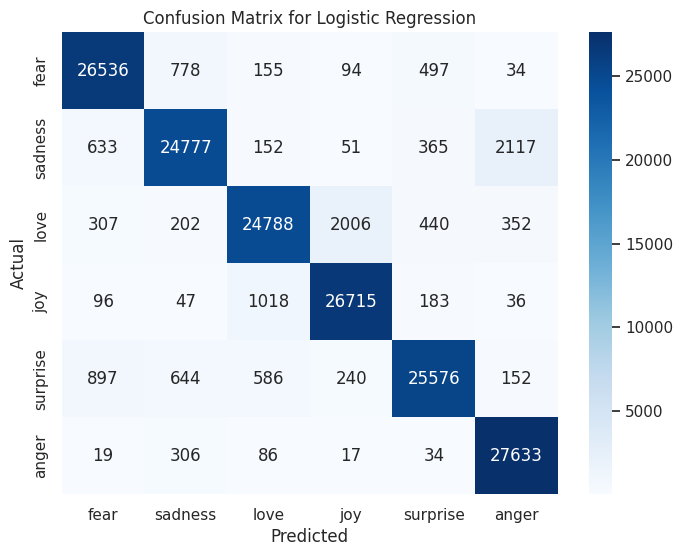

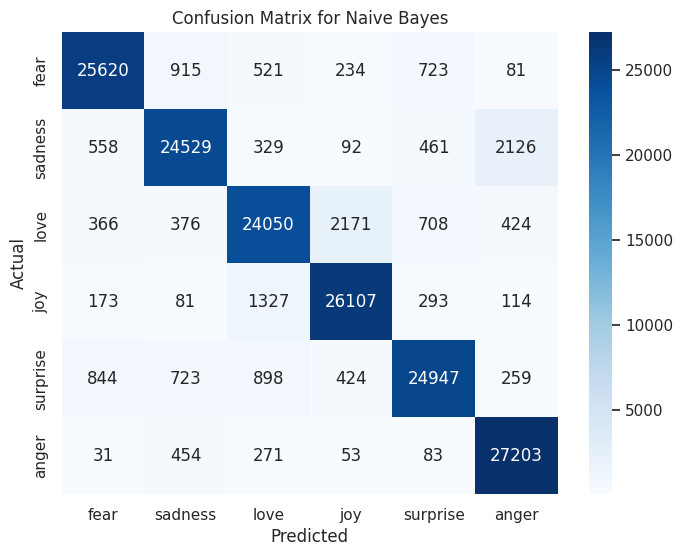

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    """
    This function draws a confusion matrix for the given true and predicted values.

    Parameters:
    - y_true: array, True labels
    - y_pred: array, Predicted labels
    - model_name: str, the name of the model to display on the plot
    - class_labels: array, list of class labels for the axis ticks
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Assuming 'df' is your DataFrame and 'label' is the column with target labels
model_labels = df['label'].unique()  # Ensure this captures all possible classes accurately

# Plot for Logistic Regression
plot_confusion_matrix(y_test_resampled, y_pred_log_reg, "Logistic Regression", model_labels)

# Plot for Naive Bayes
plot_confusion_matrix(y_test_resampled, y_pred_nb, "Naive Bayes", model_labels)